In [1]:
# Import libraries and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add the src directory to the path
sys.path.append(str(Path.cwd().parent / 'src'))

# Import our custom modules
from data.cleaning import clean_hr_data
from features.engineering import engineer_features

# Set visualization style
plt.style.use('ggplot')
sns.set_palette('Set2')
%matplotlib inline

In [2]:
# Define paths
project_root = Path.cwd().parent
input_csv = project_root / 'data' / 'processed' / 'hr_dataset.csv'
cleaned_csv = project_root / 'data' / 'processed' / 'hr_dataset_cleaned.csv'
engineered_csv = project_root / 'data' / 'processed' / 'hr_dataset_engineered.csv'

print("Input file:", input_csv.exists())

Input file: True


In [3]:
# Run data cleaning
print("Step 1: Data Cleaning")
print("-" * 50)
df_cleaned = clean_hr_data(input_csv, cleaned_csv)

Step 1: Data Cleaning
--------------------------------------------------
Loading data for cleaning...
Original shape: (2000, 11)
Found 0 duplicate rows
Checking for missing values...
Columns with missing values: 5
Cleaned data saved!!
Final shape: (2000, 11)


In [4]:
# Explore cleaned data
print("\nCleaned Data Overview:")
print("Shape:", df_cleaned.shape)
print("\nData Types:")
print(df_cleaned.dtypes.value_counts())

print("\nMissing Values Summary:")
missing_values = df_cleaned.isnull().sum()
missing_percent = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing_values,
    'missing_percentage': missing_percent
}).sort_values('missing_count', ascending=False)

# Display only columns with missing values
display(missing_df[missing_df['missing_count'] > 0])


Cleaned Data Overview:
Shape: (2000, 11)

Data Types:
int64       3
float64     2
object      1
category    1
category    1
category    1
category    1
category    1
Name: count, dtype: int64

Missing Values Summary:


,missing_count,missing_percentage
Salary,40,2.00
Attrition,40,2.00
TotalCompensation,40,2.00
Department,39,1.95
Gender,39,1.95


In [5]:
# Run feature engineering
print("\nStep 2: Feature Engineering")
print("-" * 50)
df_engineered = engineer_features(cleaned_csv, engineered_csv)


Step 2: Feature Engineering
--------------------------------------------------
Loading data for feature engineering...
Original shape: (2000, 11)
Feature-engineered data saved!!
Final shape: (2000, 17)


In [6]:
# Explore engineered features
print("\nEngineered Data Overview:")
print("Shape:", df_engineered.shape)

# Identify new features (columns that weren't in the cleaned data)
original_cols = set(df_cleaned.columns)
new_cols = set(df_engineered.columns) - original_cols

print(f"\nNew features created: {len(new_cols)}")
print("New feature names:", list(new_cols))


Engineered Data Overview:
Shape: (2000, 17)

New features created: 6
New feature names: ['AgeSquared', 'SalaryBonusRatio', 'RoleSalaryRatio', 'AttritionFlag', 'DeptSalaryRatio', 'TotalCompensationCalculated']



Summary statistics for new features:


,AgeSquared,SalaryBonusRatio,RoleSalaryRatio,AttritionFlag,DeptSalaryRatio,TotalCompensationCalculated
count,2000.000000,1960.000000,2000.000000,2000.0000,1961.000000,2000.000000
mean,1756.493000,4.961345,1.000000,0.1950,1.000000,17687.286315
std,891.306131,3.752740,0.062803,0.3963,0.063216,7231.229305
min,484.000000,-1.266999,0.000000,0.0000,0.000000,5021.510069
25%,961.000000,2.452426,0.970486,0.0000,0.968649,11399.500533
50%,1600.000000,3.838739,1.011383,0.0000,1.011033,17893.814178
75%,2500.000000,6.150486,1.039175,0.0000,1.039626,23743.278090
max,3481.000000,22.746280,1.064087,1.0000,1.066603,30004.147834



Distributions of new numerical features:


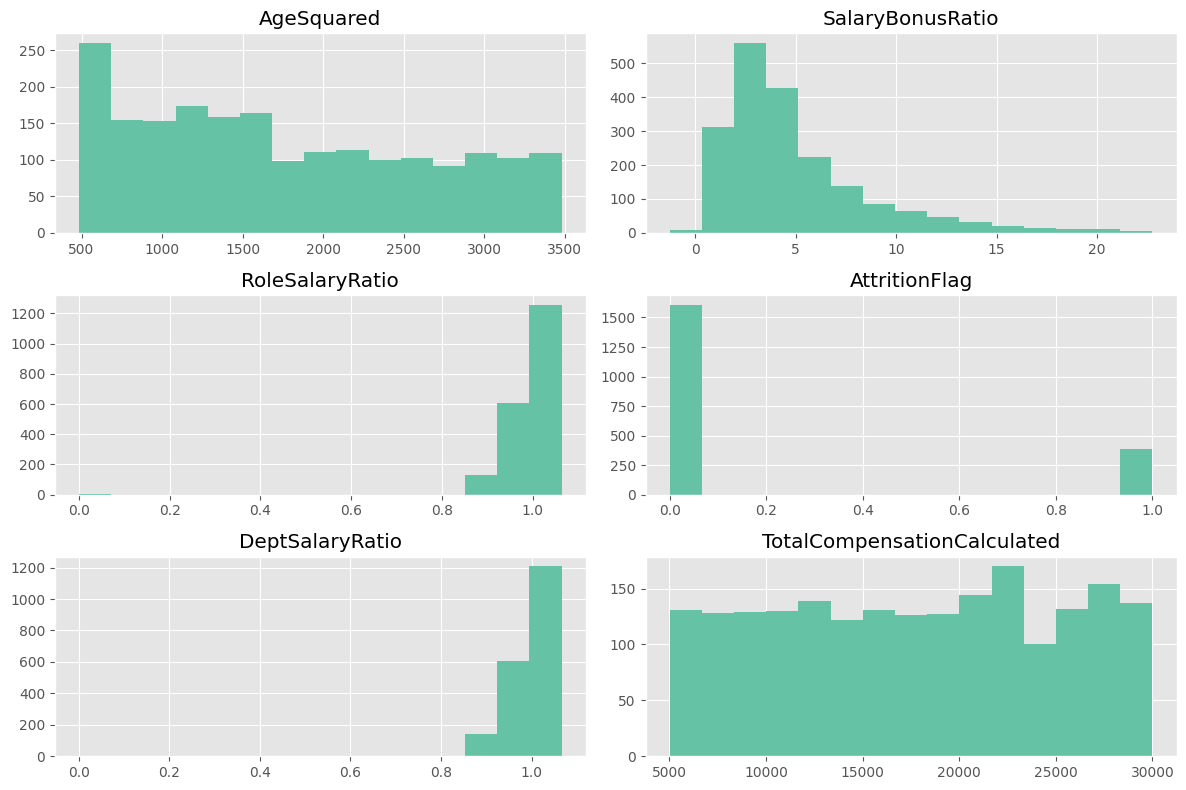

In [7]:
# Analyze new features
if new_cols:
    print("\nSummary statistics for new features:")
    display(df_engineered[list(new_cols)].describe())
    
    # Plot distributions of new numerical features
    numerical_new_features = df_engineered[list(new_cols)].select_dtypes(include=[np.number]).columns
    if len(numerical_new_features) > 0:
        print("\nDistributions of new numerical features:")
        df_engineered[numerical_new_features].hist(bins=15, figsize=(12, 8))
        plt.tight_layout()
        plt.savefig(project_root / 'notebooks' / 'outputs' / 'new_features_distribution.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

Correlation of new features with Attrition:


AttritionFlag                  1.000000
SalaryBonusRatio               0.042840
RoleSalaryRatio                0.018728
DeptSalaryRatio                0.017953
AgeSquared                     0.015189
TotalCompensationCalculated   -0.051167
dtype: float64

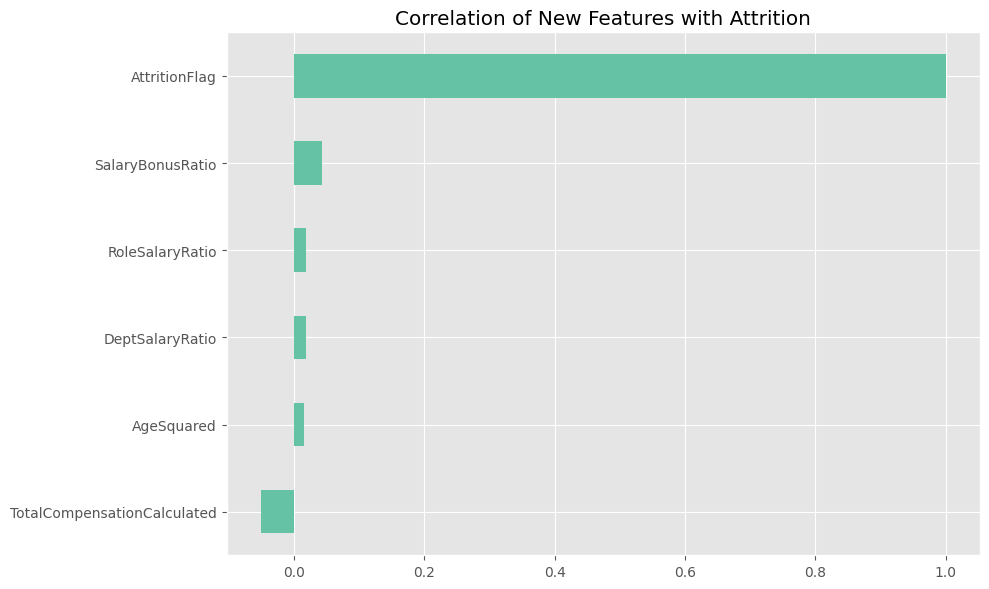

In [9]:
# Correlation analysis of new features
if new_cols:
    numerical_new_features = df_engineered[list(new_cols)].select_dtypes(include=[np.number]).columns
    if len(numerical_new_features) > 0:
        # Check correlation with target if available
        if 'Attrition' in df_engineered.columns:
            correlations = df_engineered[numerical_new_features].corrwith(df_engineered['AttritionFlag'])
            print("Correlation of new features with Attrition:")
            display(correlations.sort_values(ascending=False))
            
            # Plot correlations
            plt.figure(figsize=(10, 6))
            correlations.sort_values().plot(kind='barh')
            plt.title('Correlation of New Features with Attrition')
            plt.tight_layout()
            plt.savefig(project_root / 'notebooks' / 'outputs' / 'new_features_correlation.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()

In [11]:
# Save summary report
output_path = project_root / 'notebooks' / 'outputs' / 'feature_engineering_summary.txt'

with open(output_path, 'w') as f:
    f.write("FEATURE ENGINEERING SUMMARY REPORT\n")
    f.write("="*50 + "\n\n")
    
    f.write(f"Original dataset shape: {df_cleaned.shape}\n")
    f.write(f"Engineered dataset shape: {df_engineered.shape}\n")
    f.write(f"New features created: {len(new_cols)}\n\n")
    
    f.write("NEW FEATURES:\n")
    f.write("-"*30 + "\n")
    for feature in new_cols:
        f.write(f"{feature}\n")
    
    f.write("\nMISSING VALUES AFTER CLEANING:\n")
    f.write("-"*30 + "\n")
    f.write(missing_df[missing_df['missing_count'] > 0].to_string() + "\n")

print(f"\nSummary report saved!!")
print("Feature engineering completed successfully!")


Summary report saved!!
Feature engineering completed successfully!
